In [35]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn import under_sampling, over_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, precision_recall_curve,f1_score, log_loss

In [ ]:
X=np.load('data/x_smote.npy',allow_pickle=True)
y=np.load('data/y_smote.npy',allow_pickle=True)

In [51]:
rfc_smote = joblib.load('models/rfc_smote')


In [33]:
index=['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'land_surface_condition_Flat',
       'land_surface_condition_Moderate_slope',
       'land_surface_condition_Steep_slope', 'foundation_type_Bamboo/Timber',
       'foundation_type_Cement-Stone/Brick',
       'foundation_type_Mud_mortar-Stone/Brick', 'foundation_type_Other',
       'foundation_type_RC', 'roof_type_Bamboo/Timber-Heavy_roof',
       'roof_type_Bamboo/Timber-Light_roof', 'roof_type_RCC/RB/RBC',
       'ground_floor_type_Brick/Stone', 'ground_floor_type_Mud',
       'ground_floor_type_Other', 'ground_floor_type_RC',
       'ground_floor_type_Timber', 'other_floor_type_Not_applicable',
       'other_floor_type_RCC/RB/RBC', 'other_floor_type_TImber/Bamboo-Mud',
       'other_floor_type_Timber-Planck', 'position_Attached-1_side',
       'position_Attached-2_side', 'position_Attached-3_side',
       'position_Not_attached',
       'plan_configuration_Building_with_Central_Courtyard',
       'plan_configuration_E-shape', 'plan_configuration_H-shape',
       'plan_configuration_L-shape', 'plan_configuration_Multi-projected',
       'plan_configuration_Others', 'plan_configuration_Rectangular',
       'plan_configuration_Square', 'plan_configuration_T-shape',
       'plan_configuration_U-shape']

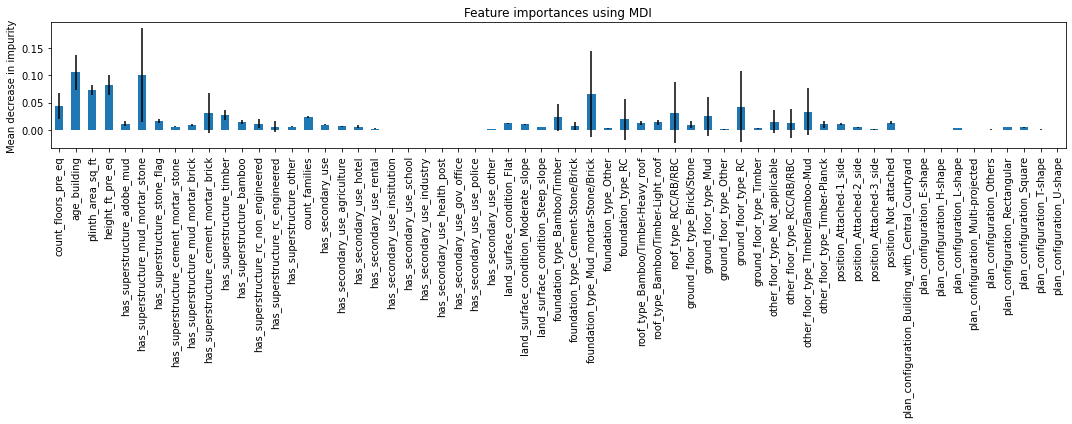

In [38]:
#impurity based importance
#feature importance based on mean decrease in impurity

feature_importances=rfc_smote.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_smote.estimators_], axis=0)
forest_importances = pd.Series(feature_importances,index=index)
fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
#feature importance based on feature permutation
from sklearn.inspection import permutation_importance
result = permutation_importance(
    rfc_smote, X, y, n_repeats=3, random_state=88, n_jobs=-1
)
forest_importances = pd.Series(result.importances_mean, index=index)

In [ ]:
forest_importances.to_pickle ('data/forest_importances_permutation')
df=pd.read_pickle('data/df')

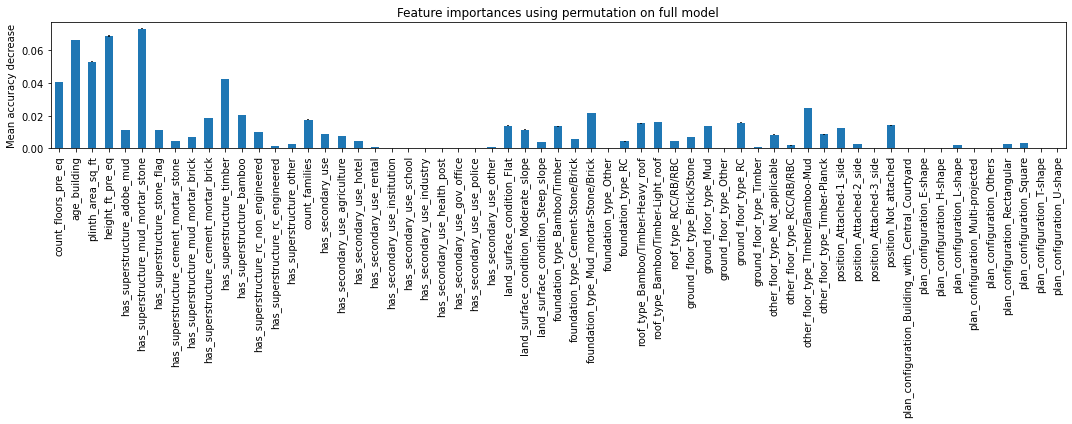

In [41]:
fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#drop in model score is indicative of how much the model depends on the feature. 

In [46]:
df=pd.read_pickle('data/forest_importances_permutation')

In [54]:
df.sort_values(ascending=False).head(10)

has_superstructure_mud_mortar_stone       0.073230
height_ft_pre_eq                          0.068742
age_building                              0.066358
plinth_area_sq_ft                         0.053115
has_superstructure_timber                 0.042644
count_floors_pre_eq                       0.040709
other_floor_type_TImber/Bamboo-Mud        0.024744
foundation_type_Mud_mortar-Stone/Brick    0.021505
has_superstructure_bamboo                 0.020430
has_superstructure_cement_mortar_brick    0.018437
dtype: float64

In [9]:
X=pd.read_pickle('data/X')
y=pd.read_pickle('data/y')

In [10]:
print(X.shape)
print(y.shape)

(758949, 61)
(758949,)


In [11]:
#only take top 6 features
X=X[['has_superstructure_mud_mortar_stone',
'height_ft_pre_eq',                          
'age_building',                              
'plinth_area_sq_ft',                         
'has_superstructure_timber',                 
'count_floors_pre_eq']]

,has_superstructure_mud_mortar_stone,height_ft_pre_eq,age_building,plinth_area_sq_ft,has_superstructure_timber,count_floors_pre_eq
0,1,9,9,288,0,1
1,1,9,15,364,0,1
2,1,9,20,384,0,1
3,1,9,20,312,0,1
4,1,9,30,308,0,1
...,...,...,...,...,...,...
762101,1,18,60,165,0,2
762102,1,18,35,342,0,2
762103,1,18,35,342,0,2
762104,1,18,19,306,0,2


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 88, stratify = y,shuffle=True)   

In [16]:
std = StandardScaler()
std.fit(X_train.values)
X_train_scaled = std.transform(X_train.values)
X_test_scaled= std.transform(X_test.values)

In [32]:
RUS=under_sampling.RandomUnderSampler(sampling_strategy='auto',random_state=88) #63m
X_RUS,y_RUS=RUS.fit_resample(X_train_scaled,y_train)

Class=Grade 1, n=62752 (8.268%)
Class=Grade 2, n=62752 (8.268%)
Class=Grade 3, n=62752 (8.268%)
Class=Grade 4, n=62752 (8.268%)
Class=Grade 5, n=62752 (8.268%)


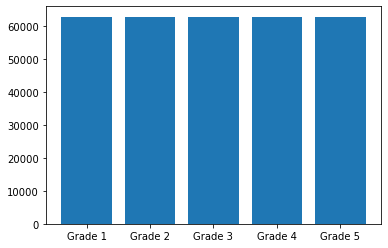

In [33]:
counter = Counter(y_RUS)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [34]:
#use tuned hyperparameters from gridsearch with SMOTE
mini_model = RandomForestClassifier(n_estimators=10, max_depth =10, n_jobs=-1)
mini_model.fit(X_RUS, y_RUS)

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1)

In [41]:
pred = mini_model.predict_proba(X_RUS)

In [42]:
pred

array([[0.79116871, 0.16493681, 0.02732724, 0.00534661, 0.01122063],
       [0.60652521, 0.2574225 , 0.0838151 , 0.03513323, 0.01710396],
       [0.04014493, 0.12926831, 0.2400513 , 0.29804352, 0.29249195],
       ...,
       [0.0304729 , 0.08572268, 0.162852  , 0.33680243, 0.38414999],
       [0.01999751, 0.06353564, 0.12221902, 0.19984195, 0.59440589],
       [0.06019885, 0.15199621, 0.24101493, 0.26998145, 0.27680855]])

In [43]:
y_RUS

0         Grade 1
1         Grade 1
2         Grade 1
3         Grade 1
4         Grade 1
           ...   
313755    Grade 5
313756    Grade 5
313757    Grade 5
313758    Grade 5
313759    Grade 5
Name: damage_grade, Length: 313760, dtype: object